<a href="https://colab.research.google.com/github/rahiakela/deep_learning_for_vision_systems/blob/5-advanced-cnn-architectures/1_lenet5_implementation_with_keras_using_mnist_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LeNet5 implementation with Keras using MNIST dataset

In 1998, LeCun et al. introduced in their paper “[Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)” a pioneering convolutional neural network called LeNet-5. The LeNet-5 architecture is straightforward. It is composed of 5 weight layers, hence the name LeNet-5: 3 convolutional layers + 2 fully connected layers.

**LeNet architecture**

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/LeNet-architecture.png?raw=1' width='800'/>

LeNet architecture in text:
**INPUT IMAGE => C1 => TANH => S2 => C3 => TANH => S4 => C5 => TANH => FC6 => SOFTMAX7**

Where C is the CONV layer, S is the subsampling or POOL layer, and FC is the fully connected layer.

The building components of the LeNet architecture is not new to you (it was new back in 1998). Notice that Yann LeCun and his team used tanh as an activation function instead of the nowadays stateof-the-art ReLU. This is because back in 1998, ReLU had not been used in the context of deep learning yet and it was more common to use tanh or sigmoid as an activation function in the hidden layers.

Without further ado, let’s implement LeNet-5 in Keras.





## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

TensorFlow 2.x selected.


## LeNet-5 implementation in Keras

To implement LeNet-5 in Keras, read the [original paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) and follow the architecture information from pages 6, 7 and 8. Here are the main takeaways to build the LeNet-5 network:

* **Number of filters in each CONV layer**: you can see from the diagram (and defined in the paper) that the depth (number of filters) of each convolutional layer is as follows: C1 = 6, C3 = 16, C5 = 120 layers.

* **Kernel size of each CONV layer**: from the paper, the kernel_size is = 5 x 5.

* **A subsampling layer (POOL)**: is added after each convolutional layer. The receptive field of each unit is a 2 x 2 area (i.e. pool_size = 2). Note that the LeNet-5 creators used average pooling which computes the average value of its inputs instead of the max pooling layer that we used in our earlier projects which passes the maximum value of its inputs. You can try both if you are interested to see the difference.

* **Activation function**: as we mentioned before, the creators of LeNet-5 used tanh activation function for the hidden layers because symmetric functions are believed to yield faster convergence compared to sigmoid functions.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/LeNet-architecture2.png?raw=1' width='800'/>

## Load and prepare MNIST Database

MNIST is one of the most famous datasets in the field of machine learning.

* It has 70,000 images of hand-written digits
* Very straight forward to download
* Images dimensions are 28x28
* Grayscale images

In [3]:
from tensorflow.keras.datasets import mnist

# use Keras to import pre-shuffled MNIST database
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f'The MNIST database has a training set of {str(len(X_train))} examples.')
print(f'The MNIST database has a test set of {str(len(X_test))} examples.')

11493376/11490434 [==============================] - 0s 0us/step
The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


### Visualize the First Six Training Images

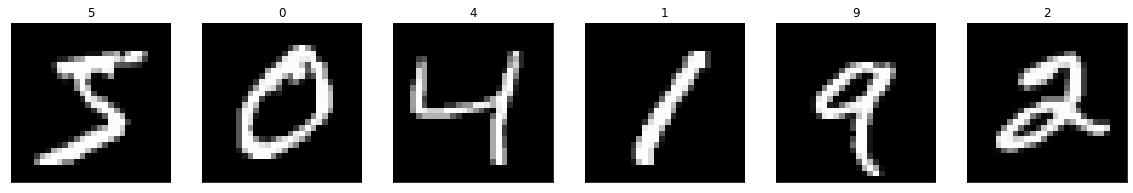

In [6]:
%matplotlib inline
import matplotlib.cm as cm

# plot first six training images
fig = plt.figure(figsize=(20, 20))
for i in range(6):
  ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i], cmap='gray')
  ax.set_title(str(y_train[i]))

### Visualize Image's pixel value

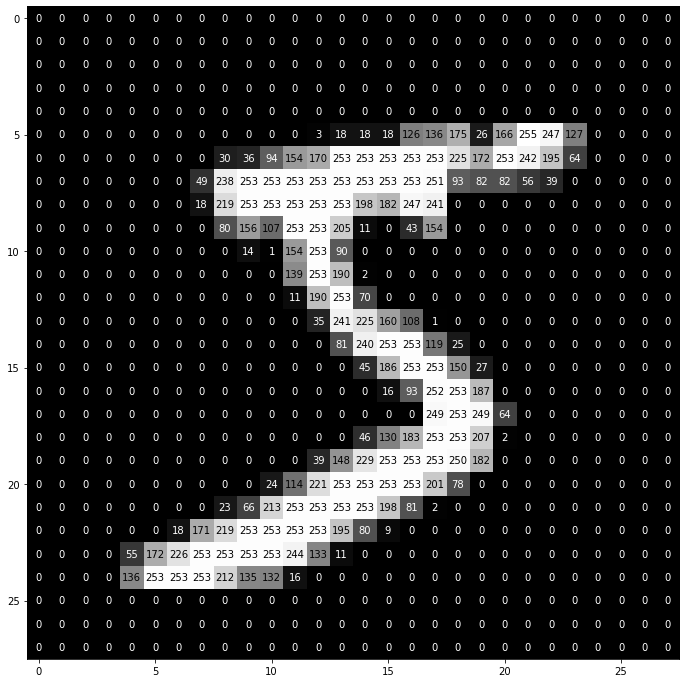

In [7]:
def visualize_input(img, ax):
  ax.imshow(img, cmap='gray')
  width, height = img.shape
  thresh = img.max() / 2.5
  for x in range(width):
    for y in range(height):
      ax.annotate(str(round(img[x][y], 2)), xy=(y, x), horizontalalignment='center', verticalalignment='center', 
                  color='white' if img[x][y] < thresh else 'black')
  
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
visualize_input(X_train[0], ax) # visualize 5's pixel value

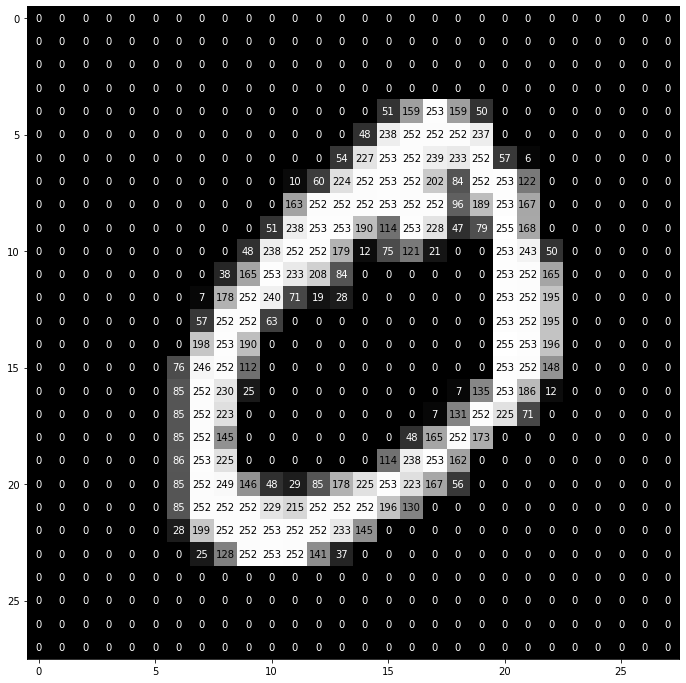

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
visualize_input(X_train[1], ax) # visualize 0's pixel value

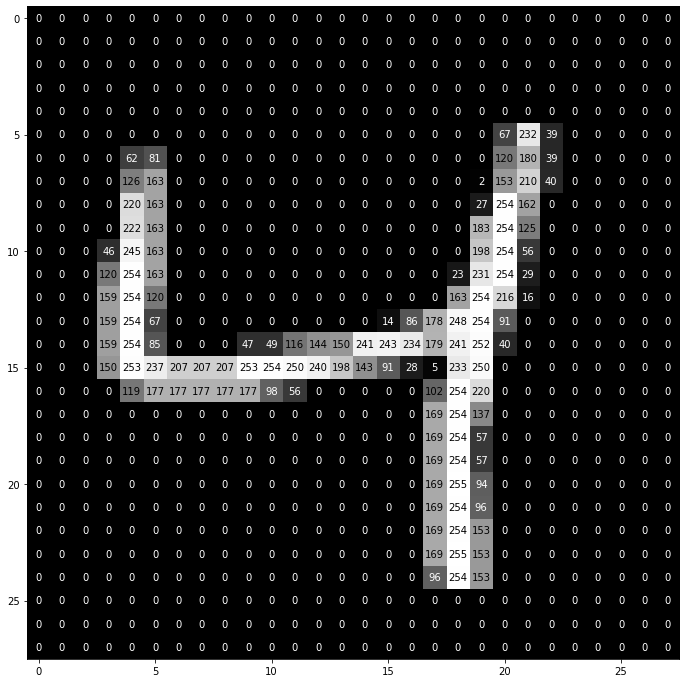

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
visualize_input(X_train[2], ax) # visualize 4's pixel value

### Preprocess input images

We will rescale the Images by Dividing Every Pixel in Every Image by 255.

In [14]:
# normalize the data to accelerate learning
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)

print(f'X_train shape: {X_train.shape}')
print(f'{X_train.shape[0]} train samples')
print(f'{X_test.shape[0]} test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


### Preprocess the labels

We will encode categorical integer labels using a One-Hot scheme.

In [15]:
from tensorflow.keras.utils import to_categorical

num_classes = 10

# print first ten (integer-valued) training labels
print(f'Integer-valued labels:\n{y_train[:10]}')

# one-hot encode the labels
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# print first ten (one-hot) training labels
print(f'One-hot labels:\n{y_train[:10]}')

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### Reshape data to fit our CNN (and input_shape)

In [17]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [19]:
# input image dimensions 28x28 pixel images.
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

print(f'image input shape: {input_shape}')
print(f'x_train shape: {X_train.shape}')
print(f'x_test shape: {X_test.shape}')

image input shape: (28, 28, 1)
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


## Define the Model Architecture

In [20]:
model = keras.models.Sequential()

# C1 Convolutional Layer
model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding='same'))

# S2 Pooling Layer
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C3 Convolutional Layer
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# S4 Pooling Layer
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# Flatten the CNN output so that we can connect it with fully connected layers
model.add(keras.layers.Flatten())

# FC6 Fully Connected Layer
model.add(keras.layers.Dense(84, activation='tanh'))

# Output Layer with softmax activation
model.add(keras.layers.Dense(10, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 84)                1

LeNet-5 is a small neural network with today’s standards. It has 61,706 parameters compared to millions of parameters in more modern networks.

### Compile the Model

The loss function is categorical cross entropy since we have multiple classes (10).

So compile the model by defining the loss function, optimizer, and performance metric

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), 
                    callbacks=[checkpointer], verbose=2, shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.07105, saving model to model.weights.best.hdf5
60000/60000 - 37s - loss: 0.1847 - accuracy: 0.9449 - val_loss: 0.0711 - val_accuracy: 0.9788
Epoch 2/20

Epoch 00002: val_loss improved from 0.07105 to 0.04931, saving model to model.weights.best.hdf5
60000/60000 - 37s - loss: 0.0648 - accuracy: 0.9801 - val_loss: 0.0493 - val_accuracy: 0.9845
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.04931
60000/60000 - 38s - loss: 0.0470 - accuracy: 0.9856 - val_loss: 0.0555 - val_accuracy: 0.9834
Epoch 4/20

Epoch 00004: val_loss improved from 0.04931 to 0.04312, saving model to model.weights.best.hdf5
60000/60000 - 37s - loss: 0.0366 - accuracy: 0.9884 - val_loss: 0.0431 - val_accuracy: 0.9865
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.04312
60000/60000 - 37s - loss: 0.0302 - accuracy: 0.9901 - val_loss: 0.0487 - val_accuracy: 0.9834
Epoch 6/20

Epoch 00006: val_loss 

## Evaluate the model

Load the Model with the Best Classification Accuracy on the Validation Set

In [0]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

Calculate the Classification Accuracy on the Test Set

In [25]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100 * score[1]
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 98.8500%


Plot accuracy/loss per epoch

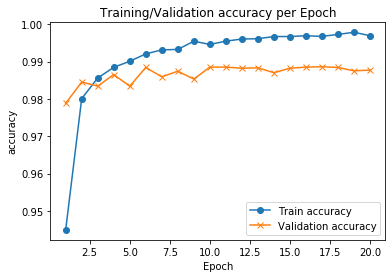

In [27]:
f, ax = plt.subplots()
ax.plot([None] + history.history['accuracy'], 'o-')
ax.plot([None] + history.history['val_accuracy'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train accuracy', 'Validation accuracy'], loc = 0)
ax.set_title('Training/Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('accuracy')
plt.show()

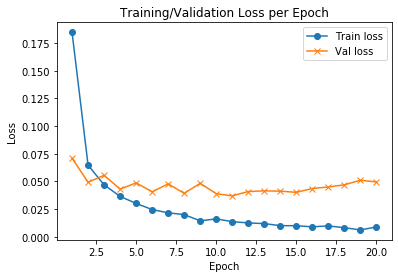

In [28]:
f, ax = plt.subplots()
ax.plot([None] + history.history['loss'], 'o-')
ax.plot([None] + history.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', "Val loss"], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

## LeNet performance on MNIST dataset

When you train LeNet-5 on the MNIST dataset you will get above 99% accuracy.

Try to re-run this experiment with ‘relu’ activation function in the hidden layers and observe the difference in the network performance.

In [29]:
model = keras.models.Sequential()

# C1 Convolutional Layer
model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same'))

# S2 Pooling Layer
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C3 Convolutional Layer
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))

# S4 Pooling Layer
model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))

# Flatten the CNN output so that we can connect it with fully connected layers
model.add(keras.layers.Flatten())

# FC6 Fully Connected Layer
model.add(keras.layers.Dense(84, activation='relu'))

# Output Layer with softmax activation
model.add(keras.layers.Dense(10, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
checkpointer = ModelCheckpoint(filepath='model.weights.best2.hdf5', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), 
                    callbacks=[checkpointer], verbose=2, shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.05844, saving model to model.weights.best2.hdf5
60000/60000 - 39s - loss: 0.1877 - accuracy: 0.9426 - val_loss: 0.0584 - val_accuracy: 0.9813
Epoch 2/20

Epoch 00002: val_loss improved from 0.05844 to 0.05072, saving model to model.weights.best2.hdf5
60000/60000 - 38s - loss: 0.0629 - accuracy: 0.9813 - val_loss: 0.0507 - val_accuracy: 0.9845
Epoch 3/20

Epoch 00003: val_loss improved from 0.05072 to 0.03793, saving model to model.weights.best2.hdf5
60000/60000 - 38s - loss: 0.0452 - accuracy: 0.9853 - val_loss: 0.0379 - val_accuracy: 0.9877
Epoch 4/20

Epoch 00004: val_loss improved from 0.03793 to 0.03446, saving model to model.weights.best2.hdf5
60000/60000 - 37s - loss: 0.0359 - accuracy: 0.9883 - val_loss: 0.0345 - val_accuracy: 0.9883
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.03446
60000/60000 - 38s - loss: 0.0298 - accuracy: 0.9903 - val_loss: 0.0489 - val_ac

In [0]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best2.hdf5')

In [33]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100 * score[1]
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 99.0300%


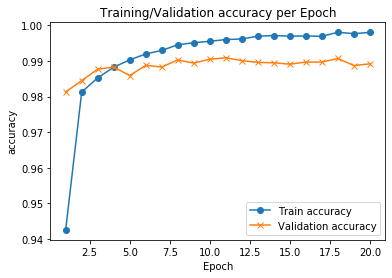

In [34]:
f, ax = plt.subplots()
ax.plot([None] + history.history['accuracy'], 'o-')
ax.plot([None] + history.history['val_accuracy'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train accuracy', 'Validation accuracy'], loc = 0)
ax.set_title('Training/Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('accuracy')
plt.show()

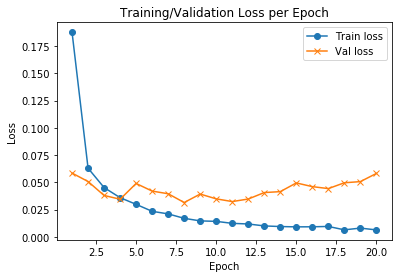

In [35]:
f, ax = plt.subplots()
ax.plot([None] + history.history['loss'], 'o-')
ax.plot([None] + history.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', "Val loss"], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()